# Load Data using quick start code 


In [3]:
import os
import pandas as pd
import json

base_path = "/raw_data/dataset/data"


def load_bdd(base_path):
    """
    Loads the complete structure of the database.

    Args:
        base_path (str): Path to the root of the database.

    Returns:
        dict: A dictionary containing the structure of cohorts, patients, and trials.
    """
    bdd_structure = {}
    for top_level in ["healthy", "ortho", "neuro"]:
        top_path = os.path.join(base_path, top_level)
        if os.path.exists(top_path):
            bdd_structure[top_level] = {}
            for cohort in os.listdir(top_path):
                cohort_path = os.path.join(top_path, cohort)
                if os.path.isdir(cohort_path):
                    bdd_structure[top_level][cohort] = [
                        patient for patient in os.listdir(cohort_path) if os.path.isdir(os.path.join(cohort_path, patient))
                    ]
    return bdd_structure



print(load_bdd(base_path))

{'healthy': {'HS': ['HS_24', 'HS_53', 'HS_25', 'HS_42', 'HS_57', 'HS_15', 'HS_48', 'HS_46', 'HS_8', 'HS_52', 'HS_29', 'HS_6', 'HS_14', 'HS_17', 'HS_7', 'HS_55', 'HS_47', 'HS_4', 'HS_60', 'HS_39', 'HS_67', 'HS_45', 'HS_64', 'HS_10', 'HS_2', 'HS_9', 'HS_73', 'HS_66', 'HS_13', 'HS_49', 'HS_27', 'HS_36', 'HS_43', 'HS_5', 'HS_41', 'HS_20', 'HS_18', 'HS_50', 'HS_69', 'HS_68', 'HS_21', 'HS_12', 'HS_38', 'HS_58', 'HS_32', 'HS_23', 'HS_16', 'HS_56', 'HS_54', 'HS_65', 'HS_44', 'HS_35', 'HS_26', 'HS_51', 'HS_40', 'HS_1', 'HS_30', 'HS_71', 'HS_37', 'HS_70', 'HS_3', 'HS_28', 'HS_31', 'HS_19', 'HS_62', 'HS_34', 'HS_22', 'HS_11', 'HS_59', 'HS_61', 'HS_33', 'HS_63', 'HS_72']}, 'ortho': {'HOA': ['HOA_12', 'HOA_7', 'HOA_13', 'HOA_8', 'HOA_10', 'HOA_6', 'HOA_5', 'HOA_11', 'HOA_14', 'HOA_1', 'HOA_15', 'HOA_4', 'HOA_9', 'HOA_3', 'HOA_2'], 'KOA': ['KOA_12', 'KOA_3', 'KOA_5', 'KOA_17', 'KOA_2', 'KOA_1', 'KOA_18', 'KOA_14', 'KOA_10', 'KOA_7', 'KOA_13', 'KOA_11', 'KOA_9', 'KOA_4', 'KOA_6', 'KOA_16', 'KOA_15', 

In [4]:
def load_cohort(base_path, cohort_name):
    """
    Loads information about a specific cohort.

    Args:
        base_path (str): Path to the root of the database.
        cohort_name (str): Name of the cohort to load.

    Returns:
        dict: A dictionary containing patients within the cohort.
    """
    cohort_path = None
    for top_level in ["healthy", "ortho", "neuro"]:
        top_path = os.path.join(base_path, top_level)
        if os.path.exists(top_path):
            for cohort in os.listdir(top_path):
                if cohort == cohort_name:
                    cohort_path = os.path.join(top_path, cohort)
                    cohort_top_level = top_level
                    break
    if not cohort_path:
        raise ValueError(f"The cohort '{cohort_name}' does not exist.")

    return cohort_top_level, {
        patient: os.listdir(os.path.join(cohort_path, patient))
        for patient in os.listdir(cohort_path) if os.path.isdir(os.path.join(cohort_path, patient))
    }


def load_patient(base_path, patient_name):
    """
    Loads information about a specific patient.

    Args:
        base_path (str): Path to the root of the database.
        cohort_name (str): Name of the cohort.
        patient_name (str): Name of the patient.

    Returns:
        str: Path to the patient's directory.
        list: List of trial directories for the specified patient.
    """
    cohort_name = patient_name.split("_")[0]
    top_level, cohort_data = load_cohort(base_path, cohort_name)
    if patient_name not in cohort_data:
        raise ValueError(f"The patient '{patient_name}' does not exist in cohort '{cohort_name}'.")

    patient_path = os.path.join(base_path, top_level, cohort_name, patient_name)
    return patient_path, os.listdir(patient_path)


def load_trial(base_path, trial_name):
    """
    Loads files for a specific trial.

    Args:
        base_path (str): Path to the root of the database.
        cohort_name (str): Name of the cohort.
        patient_name (str): Name of the patient.
        trial_name (str): Name of the trial.

    Returns:
        dict: A dictionary containing the trial :
            - "data_raw": Dictionary of raw sensor data organized by sensor type.
            - "data_processed": DataFrame of processed sensor data.
            - "metadata": Dictionary of metadata.
    """
    patient_name = trial_name.split("_")[0] + "_" + trial_name.split("_")[1]
    patient_path, patient_trials = load_patient(base_path, patient_name)
    if trial_name not in patient_trials:
        raise ValueError(f"The trial '{trial_name}' does not exist for patient '{patient_trials}'.")

    trial_path = os.path.join(patient_path, trial_name)

    # Load the data files
    # data_raw = load_data_raw(trial_path)
    data_processed = load_data_processed(trial_path)

    # Load the metadata
    metadata = load_metadata(trial_path)

    return { "data_processed": data_processed, "metadata": metadata}

def load_data_processed(trial_path):
    """
    Loads the processed sensor data file from a trial directory.

    Args:
        trial_path (str): Path to the trial folder.

    Returns:
        pandas.DataFrame: The processed sensor data.
    """
    processed_file = None
    for file in os.listdir(trial_path):
        if "processed" in file:
            processed_file = os.path.join(trial_path, file)
            break

    if not processed_file:
        raise ValueError(f"No processed sensor data file found in {trial_path}")


    # df = pd.read_csv(processed_file, sep='\t')
    # df = df.interpolate(method='linear')
    # df = df.dropna()
    # return df
    return pd.read_csv(processed_file, sep='\t')


def load_metadata(trial_path):
    """
    Loads the metadata file from a trial directory.

    Args:
        trial_path (str): Path to the trial folder.

    Returns:
        dict: A dictionary containing metadata.
    """
    metadata_file = None
    for file in os.listdir(trial_path):
        if "meta" in file:
            metadata_file = os.path.join(trial_path, file)
            break

    if not metadata_file:
        raise ValueError(f"No metadata file found in {trial_path}")

    with open(metadata_file, 'r') as f:
        metadata = json.load(f)

    return metadata



load_trial(base_path,"ACL_1_2")

{'data_processed':       PacketCounter  HE_Acc_X  HE_Acc_Y  HE_Acc_Z  HE_FreeAcc_X  HE_FreeAcc_Y  \
 0                 0  9.773163 -0.265139 -0.296501      0.542384     -0.270454   
 1                 1  9.696194 -0.231283 -0.284111      0.576240     -0.193485   
 2                 2  9.609803 -0.209699 -0.274288      0.597824     -0.107093   
 3                 3  9.514040 -0.208877 -0.268032      0.598645     -0.011330   
 4                 4  9.421570 -0.230717 -0.263755      0.576805      0.081140   
 ...             ...       ...       ...       ...           ...           ...   
 3025           3025  9.680672 -0.374016  1.410102      0.433506     -0.177963   
 3026           3026  9.692176 -0.382578  1.407213      0.424945     -0.189467   
 3027           3027  9.707807 -0.382991  1.402879      0.424532     -0.205097   
 3028           3028  9.724646 -0.374758  1.396374      0.432765     -0.221936   
 3029           3029  9.741057 -0.361005  1.388161      0.446518     -0.238348  

# Plot step detection using quick start

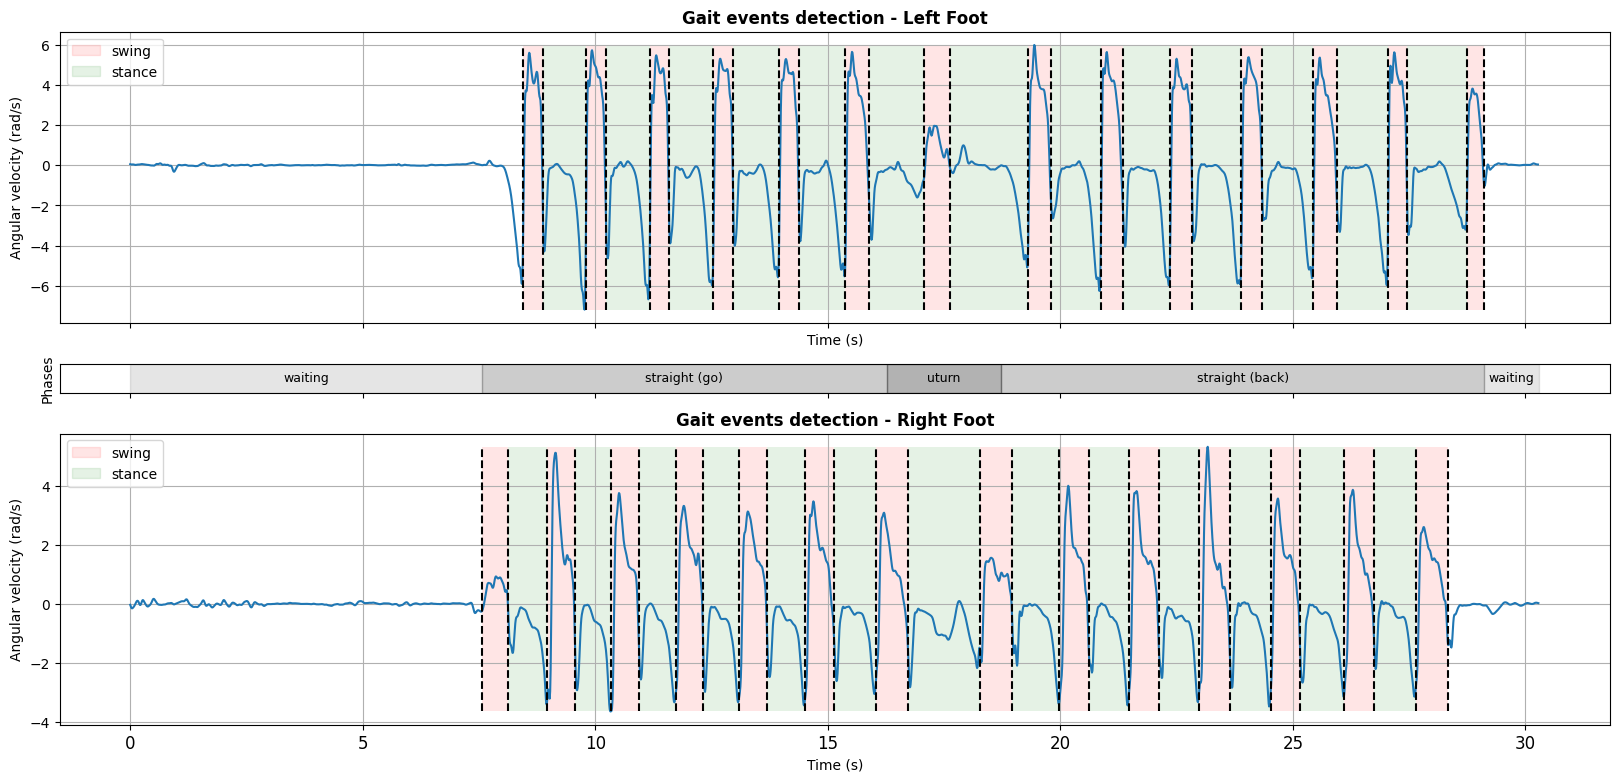

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import patches


def plot_segmentation_gait_events(trial):
    """Plot the final figure for step detection and save the fig in the output folder as png file.

    Parameters
    ----------
    trial {dict} -- dictionary with the trial data
        trial["metadata"] {dict} -- dictionary with the metadata from which are constructed :
            - gait_events {dictionary} -- dictionary with the detected gait events
            - seg {dict} -- dictionary with 4 segmentation limits ('gait start', 'uturn start', 'uturn end', 'gait end')
            - freq {int} -- acquisition frequency
        trial["data"] {dict} -- dictionary with pandas dataframe with raw data from the sensors

    """

    gait_events = {"LF": trial["metadata"]["leftGaitEvents"],
                   "RF": trial["metadata"]["rightGaitEvents"]}
    seg = {"gait start": min(np.min(trial["metadata"]["leftGaitEvents"]), np.min(trial["metadata"]["rightGaitEvents"])),
           "uturn start": trial["metadata"]["uturnBoundaries"][0],
           "uturn end": trial["metadata"]["uturnBoundaries"][1],
           "gait end": max(np.max(trial["metadata"]["leftGaitEvents"]), np.max(trial["metadata"]["rightGaitEvents"]))}
    freq = trial["metadata"]["freq"]

    data = trial["data_processed"]

    name = "Gait events detection - "

    fig, ax = plt.subplots(3, figsize=(20, 9), sharex=True, sharey=False, gridspec_kw={'height_ratios': [10, 1, 10]})

    ax[0].grid()
    ax[2].grid()

    # Phases segmentation
    # Phase 0: waiting
    ax[1].add_patch(patches.Rectangle((0, 0),  # (x,y)
                                      seg['gait start'] / freq,  # width
                                      1,  # height
                                      alpha=0.1, color="k"))
    ax[1].text(seg['gait start'] / (2 * freq), 0.5, 'waiting', fontsize=9, horizontalalignment='center',
               verticalalignment='center')

    # Phase 1: go
    ax[1].add_patch(patches.Rectangle((seg['gait start'] / freq, 0),  # (x,y)
                                      (seg['uturn start'] - seg['gait start']) / freq,  # width
                                      1,  # height
                                      alpha=0.2, color="k"))
    ax[1].text(seg['gait start'] / freq + (seg['uturn start'] - seg['gait start']) / (2 * freq), 0.5, 'straight (go)',
               fontsize=9,
               horizontalalignment='center', verticalalignment='center')

    # Phase 2: uturn
    ax[1].add_patch(patches.Rectangle((seg['uturn start'] / freq, 0),  # (x,y)
                                      (seg['uturn end'] - seg['uturn start']) / freq,  # width
                                      1,  # height
                                      alpha=0.3, color="k"))
    ax[1].text(seg['uturn start'] / freq + (seg['uturn end'] - seg['uturn start']) / (2 * freq), 0.5, 'uturn',
               fontsize=9,
               horizontalalignment='center', verticalalignment='center')

    # Phase 3: back
    ax[1].add_patch(patches.Rectangle((seg['uturn end'] / freq, 0),  # (x,y)
                                      (seg['gait end'] - seg['uturn end']) / freq,  # width
                                      1,  # height
                                      alpha=0.2, color="k"))
    ax[1].text(seg['uturn end'] / freq + (seg['gait end'] - seg['uturn end']) / (2 * freq), 0.5, 'straight (back)',
               fontsize=9,
               horizontalalignment='center', verticalalignment='center')

    # Phase 4: waiting
    ax[1].add_patch(patches.Rectangle((seg['gait end'] / freq, 0),  # (x,y)
                                      (len(data["PacketCounter"]) - seg['gait end']) / freq,  # width
                                      1,  # height
                                      alpha=0.1, color="k"))
    ax[1].text(seg['gait end'] / freq + (len(data["PacketCounter"]) - seg['gait end']) / (2 * freq), 0.5, 'waiting',
               fontsize=9,
               horizontalalignment='center', verticalalignment='center')

    ax[0].set(xlabel='Time (s)', ylabel='Angular velocity (rad/s)')
    ax[0].set_title(label=name + "Left Foot", weight='bold')
    ax[0].xaxis.set_tick_params(labelsize=12)
    ax[1].set(ylabel='Phases')
    ax[1].set_yticks([])
    ax[2].set(xlabel='Time (s)', ylabel='Angular velocity (rad/s)')
    ax[2].set_title(label=name + "Right Foot", weight='bold')
    ax[2].xaxis.set_tick_params(labelsize=12)

    # ----------------------- Feet -------------------------------------------
    t_sensor = data["PacketCounter"] / freq
    for sensor in ["RF", "LF"]:
        gyr_sensor = data[sensor + "_Gyr_Y"]
        if sensor == "LF":
            ax[0].plot(t_sensor, gyr_sensor)
            n_ax = 0
        else:
            ax[2].plot(t_sensor, gyr_sensor)
            n_ax = 2
        ma_sensor = max(gyr_sensor)
        mi_sensor = min(gyr_sensor)
        for i in range(len(gait_events[sensor])):
            to = int(gait_events[sensor][i][0])
            ax[n_ax].vlines(t_sensor[to], mi_sensor, ma_sensor, 'k', '--')
            hs = int(gait_events[sensor][i][1])
            ax[n_ax].vlines(t_sensor[hs], mi_sensor, ma_sensor, 'k', '--')
            ax[n_ax].add_patch(patches.Rectangle((t_sensor[to], mi_sensor),  # (x,y)
                                                 t_sensor[hs] - t_sensor[to],  # width
                                                 ma_sensor - mi_sensor,  # height
                                                 alpha=0.1,
                                                 facecolor='red', linestyle='dotted'))
            if i < len(gait_events[sensor]) - 1:
                to_ap = int(gait_events[sensor][i + 1][0])
                ax[n_ax].add_patch(patches.Rectangle((t_sensor[hs], mi_sensor),  # (x,y)
                                                     t_sensor[to_ap] - t_sensor[hs],  # width
                                                     ma_sensor - mi_sensor,  # height
                                                     alpha=0.1,
                                                     facecolor='green', linestyle='dotted'))

    # legend
    red_patch = mpatches.Patch(color='red', alpha=0.1, label='swing')
    green_patch = mpatches.Patch(color='green', alpha=0.1, label='stance')

    ax[0].legend(handles=[red_patch, green_patch], loc="upper left")
    ax[2].legend(handles=[red_patch, green_patch], loc="upper left")

    plt.show()


trial = load_trial(base_path, "ACL_1_2")
plot_segmentation_gait_events(trial)

# Get processed file path

In [6]:
import os, json
import pandas as pd

def trialpath(base_path, trial_path):
   
    processed_file = None
    meta_file = None
    
    for f in os.listdir(trial_path):
        if "processed" in f.lower():
            processed_file = os.path.join(trial_path, f)
        if "meta" in f.lower():
            meta_file = os.path.join(trial_path, f)

    if processed_file is None or meta_file is None:
        return None 
    
  
    parts = os.path.normpath(trial_path).split(os.sep)
    group = parts[-4]  
    subject_id = parts[-2] 
    
    return processed_file, subject_id, group


****New Data Frame seperated by Subject, Group and Pathology****

In [7]:
import json

def buildtrial(base_path):
    rows = []

    for group in ["healthy", "ortho", "neuro"]:
        group_path = os.path.join(base_path, group)
        if not os.path.isdir(group_path):
            continue
        
        for cohort in os.listdir(group_path):
            cohort_path = os.path.join(group_path, cohort)
            if not os.path.isdir(cohort_path):
                continue
            
            for patient in os.listdir(cohort_path):
                patient_path = os.path.join(cohort_path, patient)
                if not os.path.isdir(patient_path):
                    continue
                
                for trial in os.listdir(patient_path):
                    trial_path = os.path.join(patient_path, trial)
                    if not os.path.isdir(trial_path):
                        continue
                    
                    processed_path = None
                    meta_path = None

                    for f in os.listdir(trial_path):
                        if "processed" in f.lower():
                            processed_path = os.path.join(trial_path, f)
                        if "meta" in f.lower():
                            meta_path = os.path.join(trial_path, f)

                    if processed_path is None or meta_path is None:
                        continue

               
                    with open(meta_path, "r") as fp:
                        metadata = json.load(fp)

                    pathologyKey = metadata.get("pathologyKey", None)

                    rows.append({
                        "processed_path": processed_path,
                        "subject_id": patient,
                        "group": group,
                        "pathologyKey": pathologyKey
                    })

    return pd.DataFrame(rows)


index_df = buildtrial(base_path)
index_df.head()


,processed_path,subject_id,group,pathologyKey
0,/kaggle/input/datasets/abrenvgigimon/gait-anal...,HS_24,healthy,HS
1,/kaggle/input/datasets/abrenvgigimon/gait-anal...,HS_24,healthy,HS
2,/kaggle/input/datasets/abrenvgigimon/gait-anal...,HS_24,healthy,HS
3,/kaggle/input/datasets/abrenvgigimon/gait-anal...,HS_24,healthy,HS
4,/kaggle/input/datasets/abrenvgigimon/gait-anal...,HS_24,healthy,HS


In [8]:
print(index_df["group"].value_counts())
print("Unique:", index_df["subject_id"].nunique())
print("Trials:", len(index_df))


group
neuro      784
healthy    360
ortho      212
Name: count, dtype: int64
Unique: 260
Trials: 1356


# Train, Test and Validation split

In [9]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(
    gss.split(index_df, groups=index_df["subject_id"])
)

train_df = index_df.iloc[train_idx].reset_index(drop=True)
test_df  = index_df.iloc[test_idx].reset_index(drop=True)


gss2 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr2_idx, va_idx = next(gss2.split(train_df, groups=train_df["subject_id"]))
val_df   = train_df.iloc[va_idx].reset_index(drop=True)
train_df = train_df.iloc[tr2_idx].reset_index(drop=True)

print(train_df["group"].value_counts())
print(val_df["group"].value_counts())
print(test_df["group"].value_counts())

group
neuro      464
healthy    244
ortho      130
Name: count, dtype: int64
group
neuro      156
healthy     53
ortho       41
Name: count, dtype: int64
group
neuro      164
healthy     63
ortho       41
Name: count, dtype: int64


In [10]:
train_case = train_df[train_df["group"].isin(["ortho", "neuro"])].reset_index(drop=True)
val_case   = val_df[val_df["group"].isin(["ortho", "neuro"])].reset_index(drop=True)
test_case = test_df[test_df["group"].isin(["ortho", "neuro"])].reset_index(drop=True)



index_df = index_df.dropna(subset=["pathologyKey"])





print(train_case["pathologyKey"].value_counts())


pathologyKey
RIL     255
CVA      85
PD       70
CIPN     54
ACL      46
KOA      45
HOA      39
Name: count, dtype: int64


**Classes and Functions to load processed IMU data and trim the gait for convolution**

In [11]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

def load_processed(processed_path):
    df = pd.read_csv(processed_path, sep="\t")
    df = df.interpolate(method="linear").dropna()
    x = df.select_dtypes(include=[np.number])
    x = x.drop(columns=["PacketCounter"], errors="ignore")
    return x.to_numpy(dtype=np.float32)

def length(arr, T):
    L, C = arr.shape
    if L >= T:
        return arr[:T]
    out = np.zeros((T, C), dtype=np.float32)
    out[:L] = arr
    return out

In [12]:
labels = {"healthy": 0, "ortho": 1, "neuro": 2}


In [13]:
class TrialDataset(Dataset):
    def __init__(self, df, label_col, labels, T=4000):
        self.df = df.reset_index(drop=True)
        self.label_col = label_col
        self.labels = labels
        self.T = T

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sig = load_processed(row["processed_path"])   
        sig = length(sig, self.T)                
        x = torch.tensor(sig.T, dtype=torch.float32)  #now proper size for convolution
        y = torch.tensor(self.labels[row[self.label_col]], dtype=torch.long)
        return x, y

In [14]:
T = 4000

train_ds = TrialDataset(train_df, label_col="group", labels=labels, T=T)
val_ds   = TrialDataset(val_df,   label_col="group", labels=labels, T=T)
test_ds  = TrialDataset(test_df,  label_col="group", labels=labels, T=T)


x0, y0 = train_ds[0]
print("X shape:", x0.shape, "y:", y0.item())


X shape: torch.Size([36, 4000]) y: 0


****Weighted Sampler to handle imbalance data****

In [15]:

y = train_df["group"].map(labels).values
counts = np.bincount(y)
class_weights = 1.0 / np.maximum(counts, 1)
print("Class weights:", class_weights)
sample_weights = class_weights[y]

import torch
from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)


Class weights: [0.00409836 0.00769231 0.00215517]


****Make data ready for training:Set batch size, add sampler to data****

In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=16, sampler=sampler, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

In [17]:

xb, yb = next(iter(train_loader))
print("Batch X:", xb.shape)
print("Batch y bincount:", torch.bincount(yb))

Batch X: torch.Size([16, 36, 4000])
Batch y bincount: tensor([6, 9, 1])


In [18]:
for x, y in train_loader:
    print(torch.bincount(y))
    break


tensor([7, 5, 4])


# Configure the Covolution Network by setting up Hyperparameters

In [19]:
#Architecture 3 CNN LAYERS, RELU activation fn, memory=64, and a final Linear fully connected layer of 256 neurons


import torch
import torch.nn as nn

class CNN1D(nn.Module):
    def __init__(self, inp, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(inp, 64, 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        f = self.features(x)
        f = f.squeeze(-1)
        out = self.classifier(f)
        return out

    def extract_features(self, x):
        f = self.features(x)
        return f.squeeze(-1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN1D(inp=36, num_classes=3).to(device)


# Define Loss function, Adam Optimiser and train the model to predict groups

In [20]:
# Loss=CrossEntropyLoss, Optimizer=Adam, no of epochs=20
from sklearn.metrics import classification_report

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

best_acc = 0.0
best = None

for epoch in range(1, 21):
    
    model.train()
    train_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)

   
    model.eval()
    ys, yh = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            pred = model(x).argmax(dim=1).cpu().numpy()
            ys.append(y.numpy())
            yh.append(pred)

    ys = np.concatenate(ys)
    yh = np.concatenate(yh)
    val_acc = (ys == yh).mean()

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best = {k: v.cpu().clone() for k, v in model.state_dict().items()}


Epoch 01 | train_loss=0.7980 | val_acc=0.7040
Epoch 02 | train_loss=0.5201 | val_acc=0.6800
Epoch 03 | train_loss=0.4462 | val_acc=0.7280
Epoch 04 | train_loss=0.3393 | val_acc=0.8160
Epoch 05 | train_loss=0.2819 | val_acc=0.6480
Epoch 06 | train_loss=0.1979 | val_acc=0.7440
Epoch 07 | train_loss=0.1635 | val_acc=0.8360
Epoch 08 | train_loss=0.0771 | val_acc=0.8200
Epoch 09 | train_loss=0.0957 | val_acc=0.7120
Epoch 10 | train_loss=0.0483 | val_acc=0.8080
Epoch 11 | train_loss=0.0405 | val_acc=0.8000
Epoch 12 | train_loss=0.0246 | val_acc=0.8120
Epoch 13 | train_loss=0.0147 | val_acc=0.8400
Epoch 14 | train_loss=0.0379 | val_acc=0.8280
Epoch 15 | train_loss=0.0335 | val_acc=0.8440
Epoch 16 | train_loss=0.0414 | val_acc=0.8440
Epoch 17 | train_loss=0.0107 | val_acc=0.8600
Epoch 18 | train_loss=0.0082 | val_acc=0.8360
Epoch 19 | train_loss=0.0517 | val_acc=0.8560
Epoch 20 | train_loss=0.0591 | val_acc=0.8360


****Save the best model****

In [21]:
model.load_state_dict(best)
print("Best validation acc:", best_acc)


Best validation acc: 0.86


****Model evaluation****

In [22]:
model.eval()
ys, yh = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        pred = model(x).argmax(dim=1).cpu().numpy()
        ys.append(y.numpy())
        yh.append(pred)

ys = np.concatenate(ys)
yh = np.concatenate(yh)

print(classification_report(ys, yh, target_names=["healthy","ortho","neuro"], digits=4))


              precision    recall  f1-score   support

     healthy     0.6429    0.7143    0.6767        63
       ortho     0.8750    0.6829    0.7671        41
       neuro     0.8795    0.8902    0.8848       164

    accuracy                         0.8172       268
   macro avg     0.7991    0.7625    0.7762       268
weighted avg     0.8232    0.8172    0.8179       268



**Map to pathology keys**

In [23]:
pk = sorted(train_case["pathologyKey"].unique().tolist())
pkid = {k:i for i,k in enumerate(pk)}
id_pk = {i:k for k,i in pkid.items()}

print("Pathology keys:", pk)
print("Num of keys:", len(pk))


Pathology keys: ['ACL', 'CIPN', 'CVA', 'HOA', 'KOA', 'PD', 'RIL']
Num of keys: 7


**Make data ready for training for pathology keys:Set batch size, add sampler to data**

In [24]:
T = 4000

train_pk = TrialDataset(train_case, label_col="pathologyKey", labels=pkid, T=T)
val_pk  = TrialDataset(val_case,   label_col="pathologyKey", labels=pkid, T=T)
test_pk = TrialDataset(test_case,  label_col="pathologyKey", labels=pkid, T=T)










x0, y0 = train_pk[0]
print("PK X shape:", x0.shape, "PK y:", y0.item(), "label:", id_pk[y0.item()])


PK X shape: torch.Size([36, 4000]) PK y: 3 label: HOA


In [25]:
y_train_pk = train_case["pathologyKey"].map(pkid).values
counts_pk = np.bincount(y_train_pk)
class_w_pk = 1.0 / np.maximum(counts_pk, 1)
sample_w_pk = class_w_pk[y_train_pk]

sampler_pk = WeightedRandomSampler(
    weights=torch.tensor(sample_w_pk, dtype=torch.double),
    num_samples=len(sample_w_pk),
    replacement=True
)


In [26]:
train_pk_loader = DataLoader(train_pk, batch_size=16, sampler=sampler_pk, shuffle=False)
val_pk_loader   = DataLoader(val_pk, batch_size=32, shuffle=False)
test_pk_loader  = DataLoader(test_pk, batch_size=32, shuffle=False)


xb, yb = next(iter(train_pk_loader))
print("PK Batch X:", xb.shape)
print("PK Batch y bincount:", torch.bincount(yb))


PK Batch X: torch.Size([16, 36, 4000])
PK Batch y bincount: tensor([4, 2, 1, 5, 1, 2, 1])


**Call model**

In [27]:
pk_model = CNN1D(inp=36, num_classes=len(pkid)).to(device)


# Define Loss function, Adam Optimiser and train the model to predict pathology keys in each group

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(pk_model.parameters(), lr=1e-3, weight_decay=1e-4)

best_acc = 0.0
best = None

for epoch in range(1, 21):
  
    pk_model.train()
    train_loss = 0.0

    for x, y in train_pk_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = pk_model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_pk_loader.dataset)

    
    pk_model.eval()
    ys, yh = [], []
    with torch.no_grad():
        for x, y in val_pk_loader:
            x = x.to(device)
            pred = pk_model(x).argmax(dim=1).cpu().numpy()
            ys.append(y.numpy())
            yh.append(pred)

    ys = np.concatenate(ys)
    yh = np.concatenate(yh)
    val_acc = (ys == yh).mean()

    print(f"[PK] Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best = {k: v.cpu().clone() for k, v in pk_model.state_dict().items()}


pk_model.load_state_dict(best)
print("Best PK validation acc:", best_acc)


[PK] Epoch 01 | train_loss=1.6954 | val_acc=0.2335
[PK] Epoch 02 | train_loss=1.3696 | val_acc=0.3959
[PK] Epoch 03 | train_loss=1.1792 | val_acc=0.2589
[PK] Epoch 04 | train_loss=1.1978 | val_acc=0.3655
[PK] Epoch 05 | train_loss=0.9130 | val_acc=0.3096
[PK] Epoch 06 | train_loss=0.7656 | val_acc=0.4518
[PK] Epoch 07 | train_loss=0.7026 | val_acc=0.4619
[PK] Epoch 08 | train_loss=0.5561 | val_acc=0.5127
[PK] Epoch 09 | train_loss=0.4777 | val_acc=0.3858
[PK] Epoch 10 | train_loss=0.3928 | val_acc=0.4518
[PK] Epoch 11 | train_loss=0.2499 | val_acc=0.5076
[PK] Epoch 12 | train_loss=0.2733 | val_acc=0.4975
[PK] Epoch 13 | train_loss=0.3447 | val_acc=0.5431
[PK] Epoch 14 | train_loss=0.2265 | val_acc=0.5584
[PK] Epoch 15 | train_loss=0.1758 | val_acc=0.5381
[PK] Epoch 16 | train_loss=0.1461 | val_acc=0.4264
[PK] Epoch 17 | train_loss=0.1282 | val_acc=0.5533
[PK] Epoch 18 | train_loss=0.1184 | val_acc=0.4772
[PK] Epoch 19 | train_loss=0.1815 | val_acc=0.5228
[PK] Epoch 20 | train_loss=0.07

In [29]:
pk_model.eval()
ys, yh = [], []
with torch.no_grad():
    for x, y in test_pk_loader:
        x = x.to(device)
        pred = pk_model(x).argmax(dim=1).cpu().numpy()
        ys.append(y.numpy())
        yh.append(pred)

ys = np.concatenate(ys)
yh = np.concatenate(yh)

print(classification_report(
    ys, yh,
    target_names=[id_pk[i] for i in range(len(pkid))],
    digits=4
))


              precision    recall  f1-score   support

         ACL     1.0000    0.6429    0.7826        14
        CIPN     0.0000    0.0000    0.0000        24
         CVA     0.4074    0.5238    0.4583        21
         HOA     0.0833    0.2222    0.1212         9
         KOA     0.0000    0.0000    0.0000        18
          PD     0.1538    0.0400    0.0635        50
         RIL     0.4057    0.6232    0.4914        69

    accuracy                         0.3268       205
   macro avg     0.2929    0.2932    0.2739       205
weighted avg     0.2877    0.3268    0.2866       205



In [30]:
pk_model.eval()

x_sample, y_sample = train_pk[0]
x_sample = x_sample.unsqueeze(0).to(device)

with torch.no_grad():
    deep_features = pk_model.extract_features(x_sample)

print("Deep CNN features shape:", deep_features.shape)
print("First 10 deep features:")
print(deep_features[0][:10])

Deep CNN features shape: torch.Size([1, 256])
First 10 deep features:
tensor([0.0860, 1.8051, 0.8681, 1.2791, 0.6661, 1.4331, 1.0568, 3.1078, 2.4614,
        2.0253], device='cuda:0')


In [31]:
id_group = {v:k for k,v in labels.items()} #labels for id to group



# Craete a hierarchial model with case-control stratergy

In [32]:
def hierarchical_predict(x):
    x = x.to(device)
    group_pred = model(x).argmax(dim=1).item()
    group_name = id_group[group_pred]
    if group_name == "healthy":
        return group_name, "HS"
    else:
        pk_pred = pk_model(x).argmax(dim=1).item()
        pk_name = id_pk[pk_pred]
        return group_name, pk_name

#Here model checks if the case is HEALTHY, NEURO or ORTHO. If HEALTHY:HS else predict pathology key for ORTHO and NEURO

# Prediction

In [33]:
group_results = []
pk_results = []
true_group = []
true_pk = []

model.eval()
pk_model.eval()

with torch.no_grad():
    for x, y in test_loader:
        for i in range(x.shape[0]):
            xi = x[i].unsqueeze(0)   
            g_pred, pk_pred = hierarchical_predict(xi)
            group_results.append(g_pred)
            pk_results.append(pk_pred)


# Results and Report

In [34]:
true_group = test_df["group"].tolist()
true_pk = test_df["pathologyKey"].tolist()


results_df = pd.DataFrame({
    "True_Group": true_group,
    "Pred_Group": group_results,
    "True_Pathology": true_pk,
    "Pred_Pathology": pk_results
})
results_df.tail()


,True_Group,Pred_Group,True_Pathology,Pred_Pathology
263,neuro,neuro,CVA,CVA
264,neuro,neuro,CVA,PD
265,neuro,neuro,CVA,CVA
266,neuro,neuro,CVA,RIL
267,neuro,neuro,CVA,RIL


In [35]:
print(classification_report(true_pk, pk_results))


              precision    recall  f1-score   support

         ACL       0.56      0.36      0.43        14
        CIPN       0.00      0.00      0.00        24
         CVA       0.41      0.43      0.42        21
         HOA       0.09      0.22      0.12         9
          HS       0.64      0.71      0.68        63
         KOA       0.00      0.00      0.00        18
          PD       0.15      0.04      0.06        50
         RIL       0.34      0.51      0.40        69

    accuracy                           0.37       268
   macro avg       0.27      0.28      0.27       268
weighted avg       0.33      0.37      0.33       268



# Retraining using Weighted Loss, Step Scheduler, and more no of Epochs(40)

In [36]:
counts = np.bincount(train_case["pathologyKey"].map(pkid).values)
class_weights = 1.0 / np.maximum(counts, 1)

criterion = nn.CrossEntropyLoss(
    weight=torch.tensor(class_weights, dtype=torch.float32).to(device)
)


optimizer = torch.optim.AdamW(pk_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_acc = 0.0
best = None

for epoch in range(1, 41):
  
    pk_model.train()
    train_loss = 0.0

    for x, y in train_pk_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = pk_model(x)
        loss = criterion(logits, y)
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    scheduler.step()
    train_loss /= len(train_pk_loader.dataset)
    

    
    pk_model.eval()
    ys, yh = [], []
    with torch.no_grad():
        for x, y in val_pk_loader:
            x = x.to(device)
            pred = pk_model(x).argmax(dim=1).cpu().numpy()
            ys.append(y.numpy())
            yh.append(pred)

    ys = np.concatenate(ys)
    yh = np.concatenate(yh)
    val_acc = (ys == yh).mean()

    print(f"[PK] Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best = {k: v.cpu().clone() for k, v in pk_model.state_dict().items()}


pk_model.load_state_dict(best)
print("Best PK validation acc:", best_acc)


from sklearn.metrics import f1_score
f1 = f1_score(ys, yh, average="macro")
print(f1)


[PK] Epoch 01 | train_loss=0.1607 | val_acc=0.4315
[PK] Epoch 02 | train_loss=0.0755 | val_acc=0.5076
[PK] Epoch 03 | train_loss=0.0968 | val_acc=0.4670
[PK] Epoch 04 | train_loss=0.0328 | val_acc=0.4873
[PK] Epoch 05 | train_loss=0.0370 | val_acc=0.5127
[PK] Epoch 06 | train_loss=0.2620 | val_acc=0.4315
[PK] Epoch 07 | train_loss=0.1072 | val_acc=0.5482
[PK] Epoch 08 | train_loss=0.0386 | val_acc=0.5076
[PK] Epoch 09 | train_loss=0.0267 | val_acc=0.4670
[PK] Epoch 10 | train_loss=0.0202 | val_acc=0.4772
[PK] Epoch 11 | train_loss=0.0147 | val_acc=0.4873
[PK] Epoch 12 | train_loss=0.0175 | val_acc=0.5076
[PK] Epoch 13 | train_loss=0.0087 | val_acc=0.5076
[PK] Epoch 14 | train_loss=0.0087 | val_acc=0.5178
[PK] Epoch 15 | train_loss=0.0118 | val_acc=0.4569
[PK] Epoch 16 | train_loss=0.0194 | val_acc=0.5178
[PK] Epoch 17 | train_loss=0.0130 | val_acc=0.5482
[PK] Epoch 18 | train_loss=0.0129 | val_acc=0.4975
[PK] Epoch 19 | train_loss=0.0108 | val_acc=0.5127
[PK] Epoch 20 | train_loss=0.00

In [37]:
def hierarchical_predict(x):
    x = x.to(device)
    group_pred = model(x).argmax(dim=1).item()
    group_name = id_group[group_pred]
    if group_name == "healthy":
        return group_name, "HS"
    else:
        pk_pred = pk_model(x).argmax(dim=1).item()
        pk_name = id_pk[pk_pred]
        return group_name, pk_name


In [38]:
group_results = []
pk_results = []
true_group = []
true_pk = []

model.eval()
pk_model.eval()

with torch.no_grad():
    for x, y in test_loader:
        for i in range(x.shape[0]):
            xi = x[i].unsqueeze(0)   
            g_pred, pk_pred = hierarchical_predict(xi)
            group_results.append(g_pred)
            pk_results.append(pk_pred)






true_group = test_df["group"].tolist()
true_pk = test_df["pathologyKey"].tolist()
print(classification_report(true_pk, pk_results))

              precision    recall  f1-score   support

         ACL       0.55      0.43      0.48        14
        CIPN       0.00      0.00      0.00        24
         CVA       0.31      0.52      0.39        21
         HOA       0.10      0.22      0.14         9
          HS       0.64      0.71      0.68        63
         KOA       0.12      0.06      0.08        18
          PD       0.15      0.08      0.10        50
         RIL       0.30      0.35      0.32        69

    accuracy                           0.35       268
   macro avg       0.27      0.30      0.27       268
weighted avg       0.32      0.35      0.33       268



**CNN Feature Out**

In [40]:
x_sample, y_sample = train_pk[0]
x_sample = x_sample.unsqueeze(0).to(device)

with torch.no_grad():
    deep_features = pk_model.extract_features(x_sample)

print("Deep CNN features shape:", deep_features.shape)
print("First 10 deep features:")
print(deep_features[0][:10])

Deep CNN features shape: torch.Size([1, 256])
First 10 deep features:
tensor([1.6002, 4.0048, 2.0443, 3.1095, 1.0785, 2.1223, 1.6501, 3.2267, 4.4540,
        4.1184], device='cuda:0')
